# Space Invaders from Atari Environments - Dueling-DDQN, A2C, and PPO implementation
#### Running environment: Google Colab

The **Atari Space Invaders** is a Atari's biggest hit game of 1980s and first intoduced in 1978. It tests both reaction to avoid danger and strategy to collect high scores.

### Reason for choosing Space Invaders
- Suggests balanced, discrete action space environment which requires agents to manage survival strategy, timing, aiming while being computational efficient.
- Fulfills our aim to compare stability, learning efficiency of different RL agents .

### Goal:
- Destroy the space invaders before reaching the earth
- collect more scores by shooting
- Avoid enemy fires

### Observation & Action Space
- **Environment:** `ALE/SpaceInvaders-v5`
- **Observation type:** RAM  
- **Observation:** 128-dimensional RAM vector
- **Actions: Space** Discrete 6 actions (`NOOP`, `LEFT`, `RIGHT`, `FIRE`, `RIGHTFIRE`, `LEFTFIRE`).  

### Reward:
- Raw score reward - measurement tracking.  
- Clipped reward - training (positive for destroy, negative for death)

---
In this notebook we have implemented and analysed the result of  **three RL agents** — **Dueling Double DQN**, **A2C**, and **PPO** — on Space Invaders environment.

## 📘 Notebook Structure

This notebook is organized into clear sections to ensure readability and reproducibility:

1. **Environment Setup** – install packages, import neccassary libraries for Space Invaders environments
2. **Agent Implementations** – implement three RL agents:  
   - **Dueling-Double DQN** (value-based, off-policy)
   - **A2C** (on-policy, actor-critic)  
   - **PPO** (on-policy, gradient clipped)   
3. **Output Comparison** – compared performance across agents using average reward plots.  
4. **Additional** -  showing **earlier implementation evidence** of Agent experiment


## 1. Environment Setup

In [1]:
# Install neccessary packages
!pip install -U "gymnasium[atari]" ale-py AutoROM

# Create a folder for the ROMs
!mkdir -p /root/.gymnasium/atari_roms

# Download and register Atari 2600 ROMs
!AutoROM --accept-license --install-dir /root/.gymnasium/atari_roms

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/root/.gymnasium/atari_roms

Existing ROMs will be overwritten.
Installed /root/.gymnasium/atari_roms/adventure.bin
Installed /root/.gymnasium/atari_roms/air_raid.bin
Installed /root/.gymnasium/atari_roms/alien.bin
Installed /root/.gymnasium/atari_roms/amidar.bin
Installed /root/.gymnasium/atari_roms/assault.bin
Installed /root/.gymnasium/atari_roms/asterix.bin
Installed /root/.gymnasium/atari_roms/asteroids.bin
Installed /root/.gymnasium/atari_roms/atlantis.bin
Installed /root/.gymnasium/atari_roms/atlantis2.bin
Installed /root/.gymnasium/atari_roms/backgammon.bin
Installed /root/.gymnasium/atari_roms/bank_heist.bin
Installed /root/.gymnasium/atari_roms/basic_math.bin
Installed /root/.gymnasium/atari_roms/battle_zone.bin
Installed /root/.gymnasium/atari_roms/beam_rider.bin
Installed /root/.gymnasium/atari_roms/berzerk.bin
Installed /root/.gymnasium/atari_roms/blackjack.bin
Installed /root/.gymnasium/atari_roms/bowl

In [2]:
# import necessary libraries
import time
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import csv

#Register Ale and test environment
import os
os.environ["ALE_ROMS"] = "/root/.gymnasium/atari_roms"  # point ALE to the ROMs
import gymnasium as gym
import ale_py  # this registers the Atari environments with Gymnasium
# Show available ALE name spaces
print("Registered namespaces:", sorted(set(k.split('/')[0] for k in gym.registry.keys())))

from gymnasium import spaces
from collections import deque, namedtuple
import moviepy as mpy
from moviepy.editor import ImageSequenceClip
from torch.distributions import Categorical
from gymnasium.wrappers import RecordEpisodeStatistics
from gymnasium.vector import SyncVectorEnv

import random
rng = np.random.default_rng()

# Which computational resource is being used (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

#Mounting google drive for CSV write/load for final reward comparison
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/COMP6008_RL_Project'
os.makedirs(base_dir, exist_ok=True)
print("Saving outputs to:", base_dir)

Registered namespaces: ['ALE', 'Acrobot-v1', 'Adventure-v0', 'Adventure-v4', 'AdventureNoFrameskip-v0', 'AdventureNoFrameskip-v4', 'AirRaid-v0', 'AirRaid-v4', 'AirRaidNoFrameskip-v0', 'AirRaidNoFrameskip-v4', 'Alien-v0', 'Alien-v4', 'AlienNoFrameskip-v0', 'AlienNoFrameskip-v4', 'Amidar-v0', 'Amidar-v4', 'AmidarNoFrameskip-v0', 'AmidarNoFrameskip-v4', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', 'Assault-v0', 'Assault-v4', 'AssaultNoFrameskip-v0', 'AssaultNoFrameskip-v4', 'Asterix-v0', 'Asterix-v4', 'AsterixNoFrameskip-v0', 'AsterixNoFrameskip-v4', 'Asteroids-v0', 'Asteroids-v4', 'AsteroidsNoFrameskip-v0', 'AsteroidsNoFrameskip-v4', 'Atlantis-v0', 'Atlantis-v4', 'AtlantisNoFrameskip-v0', 'AtlantisNoFrameskip-v4', 'BankHeist-v0', 'BankHeist-v4', 'BankHeistNoFrameskip-v0', 'BankHeistNoFrameskip-v4', 'BattleZone-v0', 'BattleZone-v4', 'BattleZoneNoFrameskip-v0', 'BattleZoneNoFrameskip-v4', 'BeamRider-v0', 'BeamRider-v4', 'BeamRiderNoFrameskip-v0', 'BeamRiderNoFrameskip-v4', 'Berzerk-v0', 'Berzer

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



Using device: cpu
Mounted at /content/drive
Saving outputs to: /content/drive/MyDrive/COMP6008_RL_Project


## 2.1 Implementing Dueling-Double DQN

**Key improvements in the implementation:**
- **Huber Loss**
- **Reward clipping**
- **Replay buffer**
- **Target network**
- **Gradient clipping**  
- **Early stopping**  

In [ ]:
def preprocess_obs(obs: np.ndarray) -> np.ndarray:
    # Changing SpaceInvaders RAM is uint8[128], and normalizing to [0,1] for stable learning
    return obs.astype(np.float32) / 255.0

# ******* Q-Network is updated by Dueling *******
class QNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate):
        super().__init__()
        # shared feature extractor (same hidden sizes that already pass)
        self.feature = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]), nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.ReLU(),
        )
        # dueling heads is added
        self.V = nn.Linear(hidden_sizes[1], 1)
        self.A = nn.Linear(hidden_sizes[1], output_size)

        # inroduced Huber loss (SmoothL1) and AdamW for more stability
        self.criterion = nn.SmoothL1Loss()
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=1e-5)

    def forward(self, x):
        z = self.feature(x)
        v = self.V(z)                      # [B,1]
        a = self.A(z)                      # [B,|A|]
        return v + a - a.mean(dim=1, keepdim=True)

    def update(self, inputs, targets, actions):
        # returns scalar loss to track convergence
        self.optimizer.zero_grad()
        q_sa = self.forward(inputs).gather(1, actions)  # [B,1]
        loss = self.criterion(q_sa, targets)            # targets shaped [B,1]
        loss.backward()
        #Gradient clipping to prevent exploding
        torch.nn.utils.clip_grad_norm_(self.parameters(), 10.0)  # keep grad clip if present
        self.optimizer.step()
        return float(loss.item())

    def copy_from(self, qnetwork):
      #Target update
        self.load_state_dict(qnetwork.state_dict())


In [ ]:
# ******* Defining transition tuple *******
# Using tuple enhance readability
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

class ReplayMemory(object):

    def __init__(self, capacity):
        #initialize with queue
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Store a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        #random sampling for training
        return random.sample(self.memory, batch_size)

    def __len__(self):
        #return current number of
        return len(self.memory)

In [ ]:
# Double Deep Q-network (DDQN)
class AgentDDQN():
    def __init__(self, env, gamma,
                 hidden_sizes=(256, 256),  #Larger MLP for RAM to improve
                 learning_rate=0.001,
                 #exploration epsilon greedy
                 epsilon=1.0,              #Start high and small decrease
                 replay_size=100_000,      #bigger buffer is good for Atari
                 minibatch_size=64,
                 #smoother target evolution
                 tau = 0.005,              #soft target mixing factor for Polyak averaging
                 target_update=2000,       #target updates every 2000 (stability)
                 label="DuelingDDQN",      #labeling for combined comparison plot
                 base_dir='/content/drive/MyDrive/COMP6008_RL_Project'):      #mounting the directory for csv
        # check if the state space has correct type
        continuous = isinstance(env.observation_space, spaces.Box) and len(env.observation_space.shape) == 1
        assert continuous, 'Observation space must be continuous with shape (n,)'
        self.state_dims = env.observation_space.shape[0]

        # check if the action space has correct type
        assert isinstance(env.action_space, spaces.Discrete), 'Action space must be discrete'
        self.num_actions = env.action_space.n

        # create Q-networks for action-value function
        self.qnet = QNetwork(self.state_dims, hidden_sizes, self.num_actions, learning_rate).to(device)
        self.target_qnet = QNetwork(self.state_dims, hidden_sizes, self.num_actions, learning_rate).to(device)

        # copy weights from Q-network to target Q-network
        self.target_qnet.copy_from(self.qnet)

        # initialise replay buffer
        self.replay_buffer = ReplayMemory(replay_size)

        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = 0.05            # Added small epsilon decrease
        self.epsilon_decay = 1.0 - (1.0 - self.epsilon_min) / 400_000   # Added decay gently over 400k spaces
        self.minibatch_size = minibatch_size
        self.target_update = target_update
        self.target_update_idx = 0
        self.losses = []       # Track for my plot
        self.q_values = []     # Track for my plot
        self.tau = tau
        self.warmup_steps = 20_000
        self.episode_rewards_raw = []
        self.episode_rewards_clipped = []
        self.label = label
        self.base_dir = base_dir
        os.makedirs(self.base_dir, exist_ok=True)
        self.csv_path = os.path.join(self.base_dir, f"{self.label}_raw_rewards.csv")

    def behaviour(self, state):
        # exploratory behaviour policy
        if rng.uniform() >= self.epsilon:
            # exploitation with probability 1-epsilon; break ties randomly
            q = self.qnet(state).detach()
            j = rng.permutation(self.num_actions)
            return torch.tensor([[j[q[0,j].argmax().item()]]], device=device, dtype=torch.long)
        else:
            # exploration with probability epsilon
            return torch.tensor([[self.env.action_space.sample()]], device=device, dtype=torch.long)

    def policy(self, state):
        # convert state to torch format
        if not torch.is_tensor(state):
            state = torch.tensor(state, device=device, dtype=torch.float)

        # Make sure [1, obs_dim] for the network
        if state.ndim == 1:
            state = state.unsqueeze(0)

        # greedy policy
        q = self.qnet(state).detach()
        return int(q.argmax(dim=1).item())   # argmax over actions per batch item
        #return q.argmax().item()

    def update(self):
        # ***** Early exit until buffer is large enough ****
        if len(self.replay_buffer) < max(self.minibatch_size, self.warmup_steps):
            return

        # **** Sample minibatch ****
        transitions = self.replay_buffer.sample(self.minibatch_size)
        batch = Transition(*zip(*transitions))

        input_batch  = torch.cat(batch.state)          # [B, 128]
        reward_batch = torch.cat(batch.reward)         # [B]
        action_batch = torch.cat(batch.action)         # [B,1]

        # mask and next states
        non_final_mask = torch.tensor(tuple(s is not None for s in batch.next_state),
                                      device=device, dtype=torch.bool)
        if non_final_mask.any():
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        else:
            non_final_next_states = torch.empty((0, self.state_dims), device=device)

        # **** Double DQN target ****
        next_state_values = torch.zeros(self.minibatch_size, device=device)
        if non_final_next_states.numel() > 0:
            next_actions = self.qnet(non_final_next_states).detach().argmax(1)   # select with online
            next_q_values = self.target_qnet(non_final_next_states).detach()     # evaluate with target
            next_state_values[non_final_mask] = next_q_values.gather(1, next_actions.unsqueeze(1)).squeeze()

        target_batch = reward_batch + self.gamma * next_state_values

        # **** Optimize ****
        loss_val = self.qnet.update(input_batch, target_batch.unsqueeze(1), action_batch)
        self.losses.append(loss_val)

        with torch.no_grad():
            avg_q = float(self.qnet(input_batch).gather(1, action_batch).mean().item())
        self.q_values.append(avg_q)

        # **** SOFT TARGET UPDATE (POLYAK) ****
        with torch.no_grad():
            tau = self.tau
            for tp, p in zip(self.target_qnet.parameters(), self.qnet.parameters()):
                tp.data.mul_(1.0 - tau).add_(tau * p.data)

        # **** EPSILON DECAY ****
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            if self.epsilon < self.epsilon_min:
                self.epsilon = self.epsilon_min

    #Early stopping when avergae raw reward plateaus over last k episodes
    def train(self, max_episodes, stop_criterion, criterion_episodes):
        num_steps = 0
        #training loop
        for episode in range(max_episodes):
            #episode reset
            state, _ = self.env.reset()
            state = preprocess_obs(state)
            state = torch.tensor(state, device=device, dtype=torch.float).unsqueeze(0)

            terminated = False
            truncated = False
            rewards_raw = 0.0
            rewards_clipped = 0.0

            while not (terminated or truncated):
                action = self.behaviour(state)
                next_state, raw_reward, terminated, truncated, _ = self.env.step(action.item())

                # training reward (clipped) + logging raw
                train_reward = float(np.clip(raw_reward, -1.0, 1.0))
                rewards_raw += float(raw_reward)
                rewards_clipped += train_reward
                reward_t = torch.tensor([train_reward], device=device, dtype=torch.float)

                if terminated:
                    next_state_t = None
                else:
                    next_state = preprocess_obs(next_state)
                    next_state_t = torch.tensor(next_state, device=device, dtype=torch.float).unsqueeze(0)

                self.replay_buffer.push(state, action, reward_t, next_state_t)
                self.update()  # will early-return until warmup reached

                state = next_state_t
                num_steps += 1

            # log per-episode
            self.episode_rewards_raw.append(rewards_raw)
            self.episode_rewards_clipped.append(rewards_clipped)
            #store the episode result for analysis
            print(f'\rEpisode {episode+1} done: steps = {num_steps}, raw={rewards_raw:.1f}, clipped={rewards_clipped:.1f}   ', end='')

            # stopping criterion uses RAW by default
            if episode >= criterion_episodes - 1 and stop_criterion(self.episode_rewards_raw[-criterion_episodes:]):
                print(f'\nStopping criterion satisfied after {episode+1} episodes')
                break

        # CSV write all reward logs, after the training loop finishes
        import pandas as pd, os

        os.makedirs(self.base_dir, exist_ok=True)
        df = pd.DataFrame({
            "episode": range(1, len(self.episode_rewards_raw) + 1),
            "raw_return": self.episode_rewards_raw,
            "clipped_return": self.episode_rewards_clipped
        })
        df.to_csv(self.csv_path, index=False)

        print(f"\n {self.label} results saved to {self.csv_path}")

        # **** Plot raw rewards (actual game scores) ****
        R = self.episode_rewards_raw
        if R:
            window = min(10, len(R))
            avg = [np.mean(R[max(0, i - window + 1):i + 1]) for i in range(len(R))]
            plt.figure(dpi=100)
            plt.plot(range(1, len(avg) + 1), avg, label='Average Rewards')
            plt.xlabel('Episodes'); plt.ylabel('Average rewards per episode (raw score)')
            plt.legend(loc='lower right'); plt.grid(True, alpha=0.3); plt.show()

    def plot_convergence(self):
        """Plot DDQN convergence metrics: training loss and average Q-values"""
        fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
        fig.suptitle('DDQN Training Convergence Analysis', fontsize=14, fontweight='bold')

        # Plot 1: Training Loss
        if self.losses:
            axes[0].plot(self.losses, color='red', alpha=0.7)
            axes[0].set_title('Training Loss')
            axes[0].set_xlabel('Updates')
            axes[0].set_ylabel('Loss')
            axes[0].grid(True, alpha=0.3)

        # Plot 2: Average Q-values
        if self.q_values:
            axes[1].plot(self.q_values, color='blue', alpha=0.7)
            axes[1].set_title('Average Q-values')
            axes[1].set_xlabel('Updates')
            axes[1].set_ylabel('Q-value')
            axes[1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    #Plotting clipped reward
    def plot_reward_comparison2(agent):
        import matplotlib.pyplot as plt
        clip = agent.episode_rewards_clipped
        if not clip:
            print("No reward data recorded.")
            return

        # Compute moving averages (10-episode window)
        window = 10
        clip_avg = [np.mean(clip[max(0, i-window+1):i+1]) for i in range(len(clip))]

        plt.figure(figsize=(8,4), dpi=120)
        plt.plot(clip_avg, label='Clipped Rewards (−1..1)', color='orange')
        plt.xlabel('Episodes')
        plt.ylabel('Average clipped reward per episode')
        plt.title('Clipped Training Rewards')
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

    @torch.no_grad()
    #Evaluation: run deterministic policy across n episodes
    def evaluate(self, n_episodes=10):
        """Greedy evaluation on RAW (unclipped) rewards."""
        rets = []
        for _ in range(n_episodes):
            state, _ = self.env.reset()
            done = False
            total = 0.0
            while not done:
                # preprocess + batch for the network
                s = preprocess_obs(state)
                s = torch.tensor(s, device=device, dtype=torch.float).unsqueeze(0)
                # GREEDY action (no epsilon, no randomness)
                action = int(self.qnet(s).argmax(dim=1).item())
                # step WITHOUT reward clipping
                next_state, raw_reward, terminated, truncated, _ = self.env.step(action)
                total += float(raw_reward)              # RAW reward here
                state = next_state
                done = terminated or truncated
            rets.append(total)
        return float(np.mean(rets)), float(np.std(rets))

    def save(self, path):
        torch.save(self.qnet.state_dict(), path)

    def load(self, path):
        #hard target update
        self.qnet.load_state_dict(torch.load(path))
        self.target_qnet.copy_from(self.qnet)  # keep targets aligned on load

Observation space: Box(0, 255, (128,), uint8)
Action space: Discrete(6)
Episode 1000 done: steps = 537113, raw=130.0, clipped=13.0   
 DuelingDDQN results saved to /content/drive/MyDrive/COMP6008_RL_Project/DuelingDDQN_raw_rewards.csv


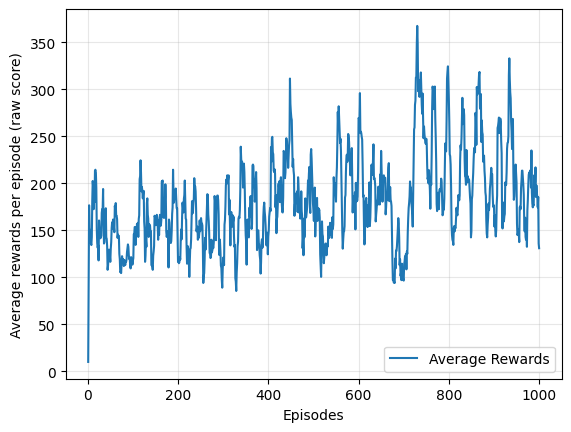

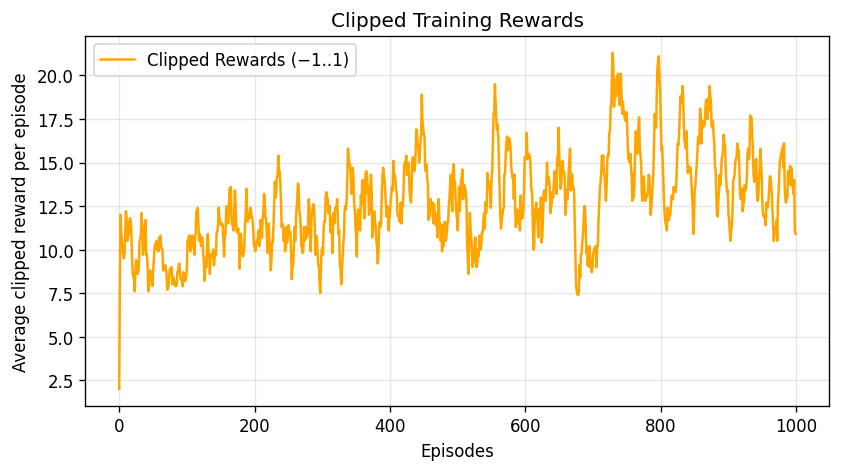

Reward: 260.0

Average evaluation reward over 10 episodes (raw game score): 235.5 ± 115.8


In [ ]:
# **** Training with hyperparameters - Space Invaders (RAM) ****
ENV_ID = "ALE/SpaceInvaders-v5"
env = gym.make(ENV_ID, obs_type="ram")
eval_env = gym.make(ENV_ID, obs_type="ram", render_mode="rgb_array")

# Header showing
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

gamma = 0.99
hidden_sizes = (256, 256)
learning_rate = 1e-3
epsilon = 1.0
replay_size = 200_000
minibatch_size = 128
target_update = 4000
max_episodes = 1000
max_steps = 5000
criterion_episodes = 20

agent = AgentDDQN(env,
                  gamma=gamma,
                  hidden_sizes=hidden_sizes,
                  learning_rate=learning_rate,
                  epsilon=epsilon,
                  replay_size=replay_size,
                  minibatch_size=minibatch_size,
                  target_update=target_update)

agent.train(max_episodes, lambda x : min(x) >= 200, criterion_episodes)

# visualise one episode
state, _ = eval_env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
frames = []
while not (terminated or truncated or steps > max_steps):
    frames.append(eval_env.render())

    # take action based on policy
    action = agent.policy(preprocess_obs(state))  #Policy also normalised obs

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    steps += 1

agent.plot_reward_comparison2()

#Storing episode metrics
print(f'Reward: {total_reward}')

# **** Evaluate average performance over several runs ****
mean_ret, std_ret = agent.evaluate(n_episodes=10)  # uses the greedy, RAW evaluation method
print(f"\nAverage evaluation reward over 10 episodes (raw game score): {mean_ret:.1f} ± {std_ret:.1f}")


# close the environment
eval_env.close()

# create and play video clip using the frames and given fps
clip = ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Displaying Double DQN convergence plots...


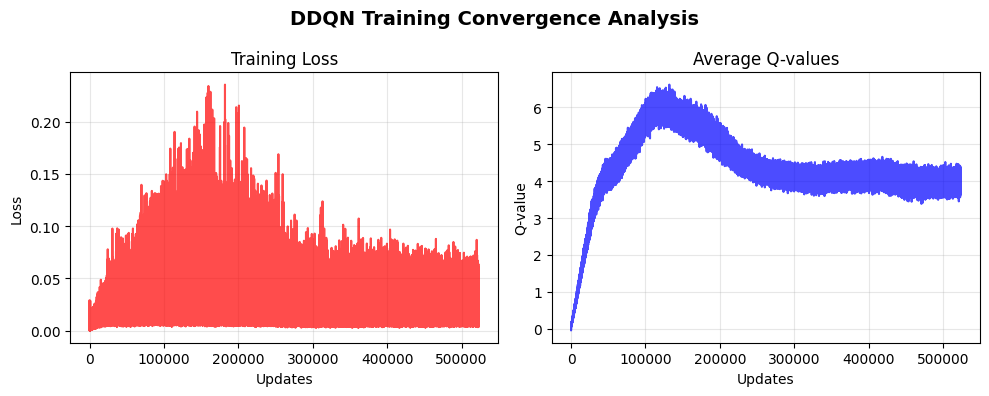

In [ ]:
# Display Double DQN convergence analysis
print("Displaying Double DQN convergence plots...")
agent.plot_convergence()

agent.save('spaceinvaders-ram.DDQN_4.pt')

## 2.2 Implementing A2C

**Key improvements (our implementation):**
- **Stochastic Policy**
- **Entropy**
- **Reward Clipping**
- **Entropy regularization**
- **Advantag normalization**
- **GAE**   
- **Early stopping**  

In [ ]:
def preprocess_obs(obs: np.ndarray) -> np.ndarray:
    # Space Invaders RAM is uint8[128]; normalize to [0,1]
    return obs.astype(np.float32) / 255.0


# **** Actor-Critic network ****
# shared MLP -> policy logits head + value head
class ActorCriticNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_actions, learning_rate):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]), nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.ReLU(),
        )
        self.pi = nn.Linear(hidden_sizes[1], num_actions)  # policy head (logits)
        self.V  = nn.Linear(hidden_sizes[1], 1)            # value head

        #Old:
        #self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        # NEW  steadier for A2C
        self.optimizer = torch.optim.RMSprop(
            self.parameters(), lr=learning_rate, alpha=0.99, eps=1e-5
        )

    def forward(self, x):
        if x.ndim == 1:
            x = x.unsqueeze(0)
        z = self.feature(x)
        logits = self.pi(z)
        value  = self.V(z).squeeze(-1)  # [B]
        return logits, value

    @torch.no_grad()
    def greedy_action(self, x):
        logits, _ = self.forward(x)
        # item() to extract the scalar value from the tensor
        return int(logits.argmax(dim=1).item())

In [ ]:
# **** A2C Agent ****
# - N-step rollout
# - logs: episode_rewards_raw, episode_rewards_clipped
# - convergence logs: policy_losses, value_losses, entropies

class AgentA2C():
    def __init__(self, env, gamma,
                 hidden_sizes=(256,256),
                 learning_rate=1e-3,
                 T=30,
                 #entropy regularization
                 entropy_coef=0.01,
                 value_coef=0.25,
                 grad_clip=0.5,
                 label="A2C",     #label for comparison analysis
                 base_dir='/content/drive/MyDrive/COMP6008_RL_Project',  #mounting driver for CSV read and write
                 make_env_fn=None):
        # observation & action checks (same pattern as DDQN)
        from gymnasium import spaces
        # Use per-env spaces if available (vectorized env), else fall back to regular spaces
        sp_obs = getattr(env, "single_observation_space", env.observation_space)
        sp_act = getattr(env, "single_action_space", env.action_space)

        assert isinstance(sp_obs, spaces.Box) and len(sp_obs.shape) == 1, \
            "Observation space must be 1-D Box for RAM."
        self.state_dims = sp_obs.shape[0]

        assert isinstance(sp_act, spaces.Discrete), "Action space must be discrete."
        self.num_actions = sp_act.n

        self.env = env
        self.n_envs = getattr(env, "num_envs", 1)
        self.make_env_fn = make_env_fn
        self.gamma = gamma
        self.T = T
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.grad_clip = grad_clip

        self.net = ActorCriticNet(self.state_dims, hidden_sizes, self.num_actions, learning_rate).to(device)

        # training logs
        self.episode_rewards_raw = []
        self.episode_rewards_clipped = []
        self.policy_losses = []
        self.value_losses = []
        self.entropies = []

        # **** entropy anneal state improvemen ****
        self.entropy_coef_start = 0.01
        self.entropy_coef_end   = 1e-5
        self.total_updates = 0
        self.max_updates_for_decay = 8_000  # horizon to finish anneal
        self.exploit_after_updates = 20_000  # hard switch to 0 afterwards
        self.label = label
        self.base_dir = base_dir
        os.makedirs(self.base_dir, exist_ok=True)
        self.csv_path = os.path.join(self.base_dir, f"{self.label}_raw_rewards.csv")

    def behaviour(self, state_tensor):
        """
        state_tensor: [B, obs_dim]  (B = n_envs during training)
        returns: actions [B] (ints), logp [B], entropy [B]
        """
        logits, _ = self.net(state_tensor)     # [B, A]

        # stabilise before building distribution
        logits = logits - logits.logsumexp(dim=1, keepdim=True)
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e2, neginf=-1e2)

        dist = Categorical(logits=logits)
        actions = dist.sample()                 # [B]
        logp    = dist.log_prob(actions)       # [B]
        entropy = dist.entropy()               # [B]
        return actions, logp, entropy


    def policy(self, state):
        """
        Greedy policy for evaluation/visualisation :
        """
        if not torch.is_tensor(state):
            state = torch.tensor(state, device=device, dtype=torch.float)
        if state.ndim == 1:
            state = state.unsqueeze(0)
        return self.net.greedy_action(state)

    def _compute_returns(self, rewards, dones, last_value):
        """
        n-step returns with bootstrap
        """
        R = last_value
        returns = []
        for r, d in reversed(list(zip(rewards, dones))):
            R = r + self.gamma * R * (1.0 - d)
            returns.append(R)
        returns.reverse()
        return torch.tensor(returns, device=device, dtype=torch.float)

    # For improvement GAE added, low variance advantage
    def _gae(self, rewards, dones, values, last_value, lam=0.95):
        """
        rewards, dones: 1D float tensors length T
        values:         1D float tensor length T (V(s_t))
        last_value:     scalar tensor V(s_{T}) for bootstrap (0 if terminal)
        returns:        V-targets = values + advantages
        """
        T = len(rewards)
        adv = torch.zeros(T, device=device)
        gae = 0.0
        for t in reversed(range(T)):
            mask = 1.0 - dones[t]                  # 0 if done at t, else 1
            next_v = last_value if t == T-1 else values[t+1]
            delta = rewards[t] + self.gamma * next_v * mask - values[t]
            gae = delta + self.gamma * lam * mask * gae
            adv[t] = gae
        returns = values + adv
        return adv, returns

    def _gae_batched(self, rewards, dones, values, last_values, lam=0.95):
        """
        rewards, dones, values: [T, N]
        last_values: [N]
        returns: advantages, returns each [T, N]
        """
        T, N = rewards.shape
        adv = torch.zeros(T, N, device=device)
        gae = torch.zeros(N, device=device)

        for t in reversed(range(T)):
            mask = 1.0 - dones[t]  # [N]
            if t == T - 1:
                next_v = last_values            # [N]
            else:
                next_v = values[t + 1]          # [N]

            delta = rewards[t] + self.gamma * next_v * mask - values[t]
            gae = delta + self.gamma * lam * mask * gae
            adv[t] = gae

        ret = values + adv
        return adv, ret


    def _a2c_update(self, logps, entropies, values, returns, advantages):
        #Added guard for non-finite stats (skip bad updates)
        if not (torch.isfinite(logps).all() and torch.isfinite(values).all() and
                torch.isfinite(returns).all() and torch.isfinite(advantages).all()):
            return  # skip this update safely

        # Normalise advantages (variance reduction) — unbiased=False avoids DoF warnings on small T
        std = advantages.std(unbiased=False)
        #advantage normalisation
        advantages = (advantages - advantages.mean()) / (std + 1e-8)

        policy_loss = -( (advantages.detach() * logps).mean() + self.entropy_coef * entropies.mean() )
        #Added Huber loss smooth l1
        value_loss  = F.smooth_l1_loss(values, returns)
        entropy     = entropies.mean()


        # **** entropy coefficient schedule ****
        p = min(1.0, self.total_updates / self.max_updates_for_decay)
        entropy_coef = self.entropy_coef_start + p * (self.entropy_coef_end - self.entropy_coef_start)
        if self.total_updates >= self.exploit_after_updates:
            entropy_coef = 0.0

        loss = policy_loss + self.value_coef * value_loss - entropy_coef * entropy

        self.net.optimizer.zero_grad()
        loss.backward()
        #Gradient Clipping
        nn.utils.clip_grad_norm_(self.net.parameters(), self.grad_clip)
        # Added extra guard — skip stepping if grads became NaN/inf
        finite = all((p.grad is None) or torch.isfinite(p.grad).all() for p in self.net.parameters())
        if not finite:
            return
        self.net.optimizer.step()

        self.policy_losses.append(float(policy_loss.item()))
        self.value_losses.append(float(value_loss.item()))
        self.entropies.append(float(entropy.item()))
        self.total_updates += 1

    #Early stopping : stop when moving-average RAW reward plateaus over last k episodes
    def train(self, max_episodes, stop_criterion, criterion_episodes):
        """
        Parallel A2C training:
          - collect T steps from N envs each update
          - compute GAE per env
          - flatten to [T*N] for the update
          - log per-episode raw/clipped rewards whenever any env finishes
        """
        total_episodes_logged = 0
        num_updates = 0

        # reset all envs to state: (N, obs_dim)
        state, _ = self.env.reset()
        state_t = torch.tensor(preprocess_obs(state), device=device, dtype=torch.float)  # [N, obs_dim]

        # per-env episode totals
        ep_raw_env  = np.zeros(self.n_envs, dtype=np.float32)
        ep_clip_env = np.zeros(self.n_envs, dtype=np.float32)

        while total_episodes_logged < max_episodes:
            # storage for one rollout across N envs
            logps, entrs = [], []
            rewards, dones, values = [], [], []

            # **** collect T steps ****
            for _ in range(self.T):
                with torch.no_grad():
                    _, v = self.net(state_t)                      # [N]
                actions, logp, entr = self.behaviour(state_t)     # [N]

                # step vector env (actions must be numpy ints)
                next_state, raw_reward, terminated, truncated, _ = self.env.step(actions.detach().cpu().numpy())
                done = np.logical_or(terminated, truncated)       # [N] bools

                # training reward (clipped) + logging raw
                train_reward = np.clip(raw_reward, -1.0, 1.0)
                ep_raw_env  += raw_reward
                ep_clip_env += train_reward

                # push tensors for this step
                logps.append(logp)  # [N]
                entrs.append(entr)  # [N]
                rewards.append(torch.tensor(train_reward, device=device, dtype=torch.float))  # [N]
                dones.append(torch.tensor(done.astype(float), device=device, dtype=torch.float))  # [N]
                values.append(v)  # [N]

                # record finished envs
                finished_ids = np.where(done)[0]
                for i in finished_ids:
                    self.episode_rewards_raw.append(float(ep_raw_env[i]))
                    self.episode_rewards_clipped.append(float(ep_clip_env[i]))
                    ep_raw_env[i] = 0.0
                    ep_clip_env[i] = 0.0
                    total_episodes_logged += 1

                # early break if we’ve logged enough episodes
                if total_episodes_logged >= max_episodes:
                    break

                state_t = torch.tensor(preprocess_obs(next_state), device=device, dtype=torch.float)  # [N, obs_dim]

            # **** bootstrap value for each env ****
            with torch.no_grad():
                _, last_values = self.net(state_t)  # [N]

            # stack step lists -> [T, N]
            if len(logps) < 2:
                continue  # rollout too short (edge case)
            logps   = torch.stack(logps, dim=0)
            entrs   = torch.stack(entrs, dim=0)
            values  = torch.stack(values, dim=0)
            rewards = torch.stack(rewards, dim=0)
            dones   = torch.stack(dones, dim=0)

            # **** GAE(λ) per env, then flatten for update ****
            advantages, returns = self._gae_batched(rewards, dones, values, last_values, lam=0.95)

            self._a2c_update(
                logps=logps.reshape(-1),
                entropies=entrs.reshape(-1),
                values=values.reshape(-1),
                returns=returns.reshape(-1),
                advantages=advantages.reshape(-1),
            )
            num_updates += 1

            # progress ping
            if total_episodes_logged % 50 == 0:
                recent = self.episode_rewards_raw[-10:] if self.episode_rewards_raw else []
                recent_mean = np.mean(recent) if recent else float('nan')
                print(f"\rEpisodes={total_episodes_logged}/{max_episodes} | updates={num_updates} | last10 raw mean={recent_mean:.1f}", end="")

        # **** Write all reward once to CSV (after training) *****
        import pandas as pd

        os.makedirs(self.base_dir, exist_ok=True)
        clipped = getattr(self, "episode_rewards_clipped",
                  getattr(self, "episode_returns", self.episode_rewards_raw))

        df = pd.DataFrame({
            "episode": range(1, len(self.episode_rewards_raw) + 1),
            "raw_return": self.episode_rewards_raw,
            "clipped_return": clipped[:len(self.episode_rewards_raw)]
        })
        df.to_csv(self.csv_path, index=False)

        print(f"\n {self.label} results saved to {self.csv_path}")

        # Raw reward plot ****
        R = self.episode_rewards_raw
        if R:
            window = min(10, len(R))
            avg = [np.mean(R[max(0, i-window+1):i+1]) for i in range(len(R))]
            plt.figure(dpi=100)
            plt.plot(range(1, len(avg)+1), avg, label='Average Rewards')
            plt.xlabel('Episodes'); plt.ylabel('Average rewards per episode (raw score)')
            plt.legend(loc='lower right'); plt.grid(True, alpha=0.3); plt.show()

    def plot_convergence(self):
        """Enhanced convergence plots for upgraded A2C (GAE + entropy anneal)."""
        fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
        fig.suptitle('A2C Training Convergence Analysis', fontsize=14, fontweight='bold')

        # Left: Policy & Value Loss
        if hasattr(self, "policy_losses") and hasattr(self, "value_losses"):
            axes[0].plot(self.policy_losses, color='red', alpha=0.6, label='Policy loss')
            axes[0].plot(self.value_losses, color='blue', alpha=0.6, label='Value loss')
            axes[0].set_title('Losses (per update)')
            axes[0].set_xlabel('Updates')
            axes[0].set_ylabel('Loss')
            axes[0].grid(True, alpha=0.3)
            axes[0].legend()

        # Right: Policy Entropy
        if hasattr(self, "entropies"):
            axes[1].plot(self.entropies, color='green', alpha=0.7)
            axes[1].set_title('Policy Entropy (Exploration)')
            axes[1].set_xlabel('Updates')
            axes[1].set_ylabel('Entropy')
            axes[1].grid(True, alpha=0.3)

            # Add reference line for max entropy (uniform random)
            import math
            max_ent = math.log(self.num_actions)   # works for vectorized or single env

            axes[1].axhline(max_ent, color='gray', linestyle='--', alpha=0.5)
            axes[1].text(0, max_ent + 0.02, f"Max entropy (log|A|={max_ent:.2f})", fontsize=8, color='gray')

        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    #Evaluation: run for deterministic policy across N episodes
    def evaluate(self, n_episodes=10):
        """
        Greedy evaluation on RAW rewards using a single (non-vector) env.
        If training used a vector env, we build one with make_env_fn.
        """
        # Build a single env for evaluation if needed
        if self.n_envs > 1:
            assert self.make_env_fn is not None, "Pass make_env_fn=make_env to AgentA2C(...) for evaluation."
            eval_env = self.make_env_fn()
        else:
            eval_env = self.env

        scores = []
        #Training Loop
        for _ in range(n_episodes):
            s, _ = eval_env.reset()
            done = False
            total = 0.0
            #Episode rollout
            while not done:
                # greedy (argmax) action
                a = self.policy(preprocess_obs(s))  # this returns a Python int for a single state
                s, r, term, trunc, _ = eval_env.step(a)
                total += float(r)
                done = term or trunc
            scores.append(total)

        # if we created a temp eval env, close it
        if eval_env is not self.env:
            eval_env.close()

        return float(np.mean(scores)), float(np.std(scores))

    def save(self, path):
        torch.save(self.net.state_dict(), path)

    def load(self, path):
        #Hard target update
        self.net.load_state_dict(torch.load(path, map_location=device))

Vector envs: 6 | obs: Box(0, 255, (128,), uint8) | act: Discrete(6)
Episodes=1000/1000 | updates=655 | last10 raw mean=164.5
✅ A2C results saved to /content/drive/MyDrive/COMP6008_RL_Project/A2C_raw_rewards.csv


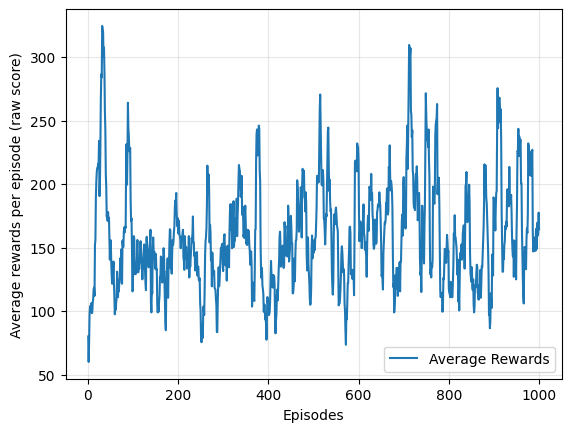

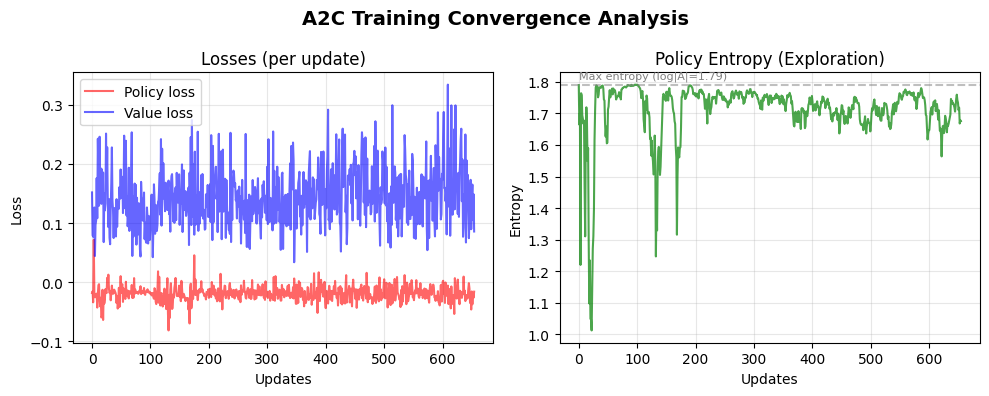


Eval (greedy, RAW score, 10 eps): 274.0 ± 17.9
Video episode reward (raw): 285.0


In [ ]:
# **** A2C training with parameters ******
ENV_ID = "ALE/SpaceInvaders-v5"

def make_env():
    # each worker makes its own RAM env
    return gym.make(ENV_ID, obs_type="ram")

n_envs = 6  #trying 4-8 parallel envs
env = gym.vector.AsyncVectorEnv([make_env for _ in range(n_envs)])  # training
eval_env = gym.make(ENV_ID, obs_type="ram", render_mode="rgb_array")  # single-env for eval/video

print("Vector envs:", n_envs,
      "| obs:", env.single_observation_space,
      "| act:", env.single_action_space)


# Hyperparameters
gamma = 0.99
hidden_sizes = (256, 256)
learning_rate = 1e-3
max_episodes = 1000
rollout_T = 128                # T-step on-policy rollout
entropy_coef = 0.01            # Entropy regularization for exploration
value_coef = 0.25
grad_clip = 0.5              # actor-critic usually smaller clip than DQN


# **** Training ****
agent = AgentA2C(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 T=rollout_T,
                 entropy_coef=entropy_coef,
                 value_coef=value_coef,
                 grad_clip=grad_clip,
                 make_env_fn=make_env) # Pass make_env for evaluation

# stop criterion: keep same as DDQN
criterion_episodes = 20
agent.train(max_episodes, lambda lastk: min(lastk) >= 300, criterion_episodes)

# Convergence plots (policy/value loss + entropy)
agent.plot_convergence()

# Greedy evaluation
mean_ret, std_ret = agent.evaluate(n_episodes=10)
print(f"\nEval (greedy, RAW score, 10 eps): {mean_ret:.1f} ± {std_ret:.1f}")

# One-episode video
state, _ = eval_env.reset()
terminated = truncated = False
steps, total_reward = 0, 0.0
max_steps = 5000
frames = []
while not (terminated or truncated or steps > max_steps):
    frames.append(eval_env.render())
    action = agent.policy(preprocess_obs(state))   # greedy action for visual
    state, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    steps += 1

print(f"Video episode reward (raw): {total_reward:.1f}")
eval_env.close()

clip = ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

## 2.3 Implementing PPO

**Key improvements (our implementation):**
- **Stochastic Policy**
- **Entropy**
- **PPO clipped surrogate**
- **Entropy regularization**
- **Reward normalization**
- **GAE**   
- **Early stopping**  

In [ ]:
# **** RAM wrappers ****
class RamNormalize(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        low  = np.zeros_like(env.observation_space.low,  dtype=np.float32)
        high = np.ones_like(env.observation_space.high, dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
    def observation(self, obs):
        return obs.astype(np.float32) / 255.0

class RamFrameStack(gym.Wrapper):
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k
        self.frames = deque(maxlen=k)
        obs_space = env.observation_space
        low  = np.repeat(obs_space.low,  k, axis=0)
        high = np.repeat(obs_space.high, k, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.frames.clear()
        for _ in range(self.k):
            self.frames.append(obs)
        return np.concatenate(self.frames, axis=0), info
    def step(self, action):
        obs, r, term, trunc, info = self.env.step(action)
        self.frames.append(obs)
        return np.concatenate(self.frames, axis=0), r, term, trunc, info

# Environment making
def make_single_env(env_id="ALE/SpaceInvaders-v5", frame_stack=4, obs_type="ram"):
    def thunk():
        env = gym.make(env_id, obs_type=obs_type)
        env = RecordEpisodeStatistics(env)
        env = RamNormalize(env)
        env = RamFrameStack(env, k=frame_stack)
        return env
    return thunk

def make_vec_env(n_envs=4, env_id="ALE/SpaceInvaders-v5", frame_stack=4, obs_type="ram"):
    env = SyncVectorEnv([make_single_env(env_id, frame_stack, obs_type) for _ in range(n_envs)])
    print(f"Vector envs: {env.num_envs} | obs: {env.single_observation_space} | act: {env.single_action_space}")
    return env

In [ ]:
# **** PPO Agent extending A2C class ****
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, n_actions, hidden_sizes=(512,512)):
        super().__init__()
        layers, last = [], obs_dim
        for h in hidden_sizes:
            layers += [nn.Linear(last, h), nn.ReLU()]
            last = h
        self.shared = nn.Sequential(*layers)
        self.pi = nn.Linear(last, n_actions)
        self.v  = nn.Linear(last, 1)
        # orthogonal init like practicals
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain=math.sqrt(2))
                nn.init.constant_(m.bias, 0)
        nn.init.orthogonal_(self.pi.weight, gain=0.01)
        nn.init.orthogonal_(self.v.weight,  gain=1.0)
    def forward(self, x):
        z = self.shared(x)
        return self.pi(z), self.v(z)
    def get_action_and_value(self, x, action=None):
        logits, value = self.forward(x)
        dist = torch.distributions.Categorical(logits=logits)
        if action is None:
            action = dist.sample()
        return action, dist.log_prob(action), dist.entropy(), value.squeeze(-1)

class AgentPPO:
    def __init__(self, env,
                 gamma=0.99, gae_lambda=0.95,  #Gae low variance advantage
                 hidden_sizes=(512,512),
                 learning_rate=3e-4,
                 rollout_T=128,     # N step rollout
                 entropy_coef=0.01,   # entropy regularization
                 grad_clip=0.5,
                 clip_eps=0.2,
                 vf_coef=0.5,
                 epochs=4,
                 minibatch_size=64,
                 label="PPO",          #labeling for comparison analysis
                 base_dir='/content/drive/MyDrive/COMP6008_RL_Project',   #mounting driver for CSV file write load
                 make_env_fn=None):
        self.env = env
        self.make_env_fn = make_env_fn
        self.gamma = gamma
        self.gae_lambda = gae_lambda
        self.entropy_coef = entropy_coef
        self.grad_clip = grad_clip
        self.clip_eps = clip_eps
        self.vf_coef = vf_coef
        self.rollout_T = rollout_T
        self.epochs = epochs
        self.minibatch_size = minibatch_size
        self.episode_rewards_raw = []      # track un-clipped raw environment returns
        self.label = label
        self.base_dir = base_dir
        os.makedirs(self.base_dir, exist_ok=True)
        self.csv_path = os.path.join(self.base_dir, f"{self.label}_raw_rewards.csv")

        obs_dim = int(np.prod(env.single_observation_space.shape))
        n_actions = env.single_action_space.n
        self.net = ActorCritic(obs_dim, n_actions, hidden_sizes).to(device)
        self.optim = optim.Adam(self.net.parameters(), lr=learning_rate, eps=1e-5)
        # Learning rate scheduler (decay every 100 updates by 10%)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=100, gamma=0.9)

        # logs
        self.policy_losses, self.value_losses, self.entropies = [], [], []
        self.kls, self.clipfracs = [], []
        self.episode_returns = deque(maxlen=1000)
        self.recent_rewards = []

    def compute_gae(self, rewards, values, dones, next_value):
        T = len(rewards)
        adv = torch.zeros_like(rewards, device=device)
        lastgaelam = 0.0
        for t in reversed(range(T)):
            next_nonterminal = 1.0 - dones[t]
            next_values = next_value if t == T - 1 else values[t + 1]
            delta = rewards[t] + self.gamma * next_values * next_nonterminal - values[t]
            lastgaelam = delta + self.gamma * self.gae_lambda * next_nonterminal * lastgaelam
            adv[t] = lastgaelam
        return adv, adv + values

    def train(self, max_episodes=300, stop_condition=None, criterion_episodes=20):
        # Episode reset
        obs, infos = self.env.reset()
        obs_dim = int(np.prod(self.env.single_observation_space.shape))
        n_envs = self.env.num_envs
        curr_returns = np.zeros(n_envs, dtype=np.float32)       # clipped episodic return
        curr_returns_raw = np.zeros(n_envs, dtype=np.float32)   # RAW episodic return
        #store episode metrics
        print(f"[PPO] n_envs={n_envs} | rollout_T={self.rollout_T} | obs_dim={obs_dim} | actions={self.env.single_action_space.n}")

        episodes_done = 0
        episode_rewards = deque(maxlen=criterion_episodes)
        start_time = time.time()

        while episodes_done < max_episodes:
            # buffers
            obs_buf     = torch.zeros((self.rollout_T, n_envs, obs_dim), device=device)
            actions_buf = torch.zeros((self.rollout_T, n_envs), device=device, dtype=torch.long)
            logp_buf    = torch.zeros_like(actions_buf, dtype=torch.float32)
            values_buf  = torch.zeros_like(logp_buf)
            rewards_buf = torch.zeros_like(logp_buf)
            dones_buf   = torch.zeros_like(logp_buf)

            # rollout
            for t in range(self.rollout_T):
                x = torch.tensor(obs, dtype=torch.float32, device=device)
                with torch.no_grad():
                    action, logprob, entropy, value = self.net.get_action_and_value(x)

                next_obs, reward, terminated, truncated, infos = self.env.step(action.cpu().numpy())

                # **** RAW before clipping ****
                raw_reward = reward.copy() if isinstance(reward, np.ndarray) else reward
                curr_returns_raw += raw_reward                        # accumulate RAW  <-- NEW

                # **** Reward Clipped for training ****
                reward = np.clip(reward, -1.0, 1.0)
                done = np.logical_or(terminated, truncated)
                curr_returns += reward                                 # accumulate clipped

                # store
                obs_buf[t]     = x
                actions_buf[t] = action
                logp_buf[t]    = logprob
                values_buf[t]  = value
                rewards_buf[t] = torch.tensor(reward, dtype=torch.float32, device=device)
                dones_buf[t]   = torch.tensor(done,   dtype=torch.float32, device=device)

                obs = next_obs

                # **** Episode accounting via final_info  ****
                got_final = False
                if isinstance(infos, dict):
                    for fi in infos.get("final_info", []):
                        if fi and "episode" in fi:
                            ep_ret = float(fi["episode"]["r"])         # this is RAW from env wrappers
                            episode_rewards.append(ep_ret)
                            self.episode_returns.append(ep_ret)
                            self.recent_rewards.append(ep_ret)
                            self.episode_rewards_raw.append(ep_ret)
                            episodes_done += 1
                            got_final = True

                # **** Fallback: if no final_info this step, use done mask ****
                if not got_final:
                    d = done.astype(bool)
                    if d.any():
                        for idx in np.where(d)[0]:
                            # clipped episodic return
                            ep_ret = float(curr_returns[idx])
                            episode_rewards.append(ep_ret)
                            self.episode_returns.append(ep_ret)
                            self.recent_rewards.append(ep_ret)

                            # RAW episodic return (true game score)
                            self.episode_rewards_raw.append(float(curr_returns_raw[idx]))

                            episodes_done += 1
                            # reset accumulators for that env
                            curr_returns[idx] = 0.0
                            curr_returns_raw[idx] = 0.0

            # advantages and returns
            with torch.no_grad():
                x = torch.tensor(obs, dtype=torch.float32, device=device)
                _, next_value = self.net.forward(x)
                next_value = next_value.squeeze(-1)
            adv, ret = self.compute_gae(rewards_buf, values_buf, dones_buf, next_value)

            # flatten
            b_obs   = obs_buf.reshape(-1, obs_dim)
            b_act   = actions_buf.reshape(-1)
            b_logp0 = logp_buf.reshape(-1)
            # advantage normalization
            b_adv   = (adv.reshape(-1) - adv.mean()) / (adv.std() + 1e-8)
            b_ret   = ret.reshape(-1)

            # PPO update
            inds = np.arange(b_obs.shape[0])
            pol_losses, val_losses, entrs, kls, clipfs = [], [], [], [], []
            for _ in range(self.epochs):
                rng.shuffle(inds)
                for start in range(0, len(inds), self.minibatch_size):
                    mb = inds[start:start + self.minibatch_size]
                    logits, value = self.net.forward(b_obs[mb])
                    dist = torch.distributions.Categorical(logits=logits)
                    new_logp = dist.log_prob(b_act[mb])
                    entropy  = dist.entropy().mean()

                    log_ratio = new_logp - b_logp0[mb]
                    ratio = torch.exp(log_ratio)

                    unclipped = ratio * b_adv[mb]
                    # PPO clipped obj
                    clipped   = torch.clamp(ratio, 1 - self.clip_eps, 1 + self.clip_eps) * b_adv[mb]
                    policy_loss = -torch.min(unclipped, clipped).mean()
                    clipfrac = (torch.abs(ratio - 1.0) > self.clip_eps).float().mean().item()

                    #Loss MSE
                    value_loss = F.mse_loss(value.squeeze(-1), b_ret[mb])
                    loss = policy_loss + self.vf_coef * value_loss - self.entropy_coef * entropy

                    self.optim.zero_grad(set_to_none=True)
                    loss.backward()
                    #Gradient clipping
                    nn.utils.clip_grad_norm_(self.net.parameters(), self.grad_clip)
                    self.optim.step()

                    with torch.no_grad():
                        # stable KL approx
                        approx_kl = ((ratio - 1) - log_ratio).mean().item()

                    pol_losses.append(policy_loss.item())
                    val_losses.append(value_loss.item())
                    entrs.append(entropy.item())
                    kls.append(approx_kl)
                    clipfs.append(clipfrac)

            self.policy_losses.append(np.mean(pol_losses))
            self.value_losses.append(np.mean(val_losses))
            self.entropies.append(np.mean(entrs))
            self.kls.append(np.mean(kls))
            self.clipfracs.append(np.mean(clipfs))
            # **** Step the LR scheduler once per PPO update ****
            self.scheduler.step()

            # **** Entropy anneal ****
            if len(self.entropies) == 150:   # after ~150 PPO updates
                old_coef = self.entropy_coef
                self.entropy_coef = 0.005
                print(f"[Anneal] entropy_coef reduced from {old_coef} → {self.entropy_coef}")


            # progress print
            recent_avg = np.mean(self.recent_rewards[-20:]) if self.recent_rewards else float('nan')
            print(f"\rEp {episodes_done:4d}/{max_episodes} | "
                  f"pi_loss={self.policy_losses[-1]:.3f} | v_loss={self.value_losses[-1]:.1f} | "
                  f"H={self.entropies[-1]:.3f} | KL={self.kls[-1]:.4f} | clipfrac={self.clipfracs[-1]:.3f} | "
                  f"recent_avg_ret={recent_avg:.2f}", end="")

            if stop_condition is not None and len(episode_rewards) >= criterion_episodes and stop_condition(episode_rewards):
                print("Stop criterion met.")
                break

        print(f"Training finished after {episodes_done} episodes in {time.time()-start_time:.1f}s")

        # ****  Write all episode rewards once to CSV (after training) ****
        import pandas as pd

        os.makedirs(self.base_dir, exist_ok=True)

        # RAW (unclipped) returns
        raw_list = list(self.episode_rewards_raw) if hasattr(self, "episode_rewards_raw") else []

        # Choose a clipped/training-style series (try common names, fall back to raw)
        clipped_series = getattr(self, "episode_rewards_clipped", None)
        if clipped_series is None:
            clipped_series = getattr(self, "episode_returns", None)   # PPO often uses a deque here
        if clipped_series is None:
            clipped_series = getattr(self, "recent_rewards", None)

        clip_list = list(clipped_series) if clipped_series is not None else []

        # If clipped list is empty/missing, reuse raw so CSV still has a consistent column
        if not clip_list:
            clip_list = raw_list.copy()

        # --- Align lengths (trim/pad) so DataFrame always builds ---
        L_raw = len(raw_list)
        L_clip = len(clip_list)
        if L_clip < L_raw:
            clip_list = clip_list + [np.nan] * (L_raw - L_clip)
        elif L_clip > L_raw:
            clip_list = clip_list[:L_raw]

        df = pd.DataFrame({
            "episode": np.arange(1, L_raw + 1),
            "raw_return": raw_list,
            "clipped_return": clip_list
        })
        df.to_csv(self.csv_path, index=False)

        print(f"\n {self.label} results saved to {self.csv_path} (episodes={L_raw})")


    # **** Reward Plotting ****
    @staticmethod
    def _moving_average(x, k=20):
        x = np.asarray(x, dtype=np.float32)
        if x.size == 0:
            return x
        k = max(1, int(k))
        return np.convolve(x, np.ones(k) / k, mode="valid")

    def plot_like_a2c(self, ma_window=20, title_suffix=" (PPO)"):
        ep_returns = list(self.episode_returns) if len(self.episode_returns) > 0 else list(self.recent_rewards)

        plt.figure(figsize=(14,4))

        # 1) Episodic Return (with moving average)
        plt.subplot(1,3,1)
        plt.title("Episodic Return" + title_suffix)
        plt.plot(ep_returns, alpha=0.3)
        if len(ep_returns) >= ma_window:
            ma = self._moving_average(ep_returns, ma_window)
            plt.plot(np.arange(len(ma)) + (ma_window - 1), ma, lw=2)
        plt.xlabel("Episode")
        plt.ylabel("Return")

        # 2) Policy / Value Loss
        plt.subplot(1,3,2)
        plt.title("Policy / Value Loss" + title_suffix)
        plt.plot(self.policy_losses, label="policy loss")
        plt.plot(self.value_losses,  label="value loss")
        plt.xlabel("Update")
        plt.legend()

        # 3) Entropy (A2C shows only entropy here)
        plt.subplot(1,3,3)
        plt.title("Entropy" + title_suffix)
        plt.plot(self.entropies, label="entropy")
        plt.xlabel("Update")
        plt.legend()

        plt.tight_layout()
        plt.show()

    # Evaluation run deterministic policy across N episodes
    def evaluate(self, n_episodes=10):
        env_eval = self.make_env_fn()
        returns = []
        #early stopping
        #training loop
        for _ in range(n_episodes):
            obs, info = env_eval.reset()
            done = False
            total_r = 0.0
            #episode rollout
            while not done:
                x = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
                with torch.no_grad():
                    action, _, _, _ = self.net.get_action_and_value(x)
                obs, reward, terminated, truncated, info = env_eval.step(action.item())
                done = terminated or truncated
                total_r += reward
            returns.append(total_r)
        env_eval.close()
        return float(np.mean(returns)), float(np.std(returns))

    def policy(self, obs):
        x = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            logits, _ = self.net.forward(x)
            return torch.argmax(logits).item()

    # **** Convergenxce plot ****
    def plot_convergence(self):
        plt.figure(figsize=(10,5))
        plt.title(" KL / ClipFrac")
        plt.plot(self.kls,       label="KL")
        plt.plot(self.clipfracs, label="clipfrac")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # **** Reward plotting ****
    def plot_raw_rewards(self):
        R = self.episode_rewards_raw
        if R:
            window = min(10, len(R))
            avg = [np.mean(R[max(0, i - window + 1):i + 1]) for i in range(len(R))]
            plt.figure(dpi=100)
            plt.plot(range(1, len(avg) + 1), avg, label='Average Rewards')
            plt.xlabel('Episodes')
            plt.ylabel('Average rewards per episode (raw score)')
            plt.legend(loc='lower right')
            plt.grid(True, alpha=0.3)
            plt.title('Episodic Raw Game Score (Unclipped Rewards)')
            plt.show()
        else:
            print("No raw reward data recorded yet.")


Vector envs: 6 | obs: Box(0.0, 1.0, (512,), float32) | act: Discrete(6)
[PPO] n_envs=6 | rollout_T=512 | obs_dim=512 | actions=6
Ep  816/1000 | pi_loss=-0.010 | v_loss=0.1 | H=1.519 | KL=0.0081 | clipfrac=0.112 | recent_avg_ret=14.80[Anneal] entropy_coef reduced from 0.015 → 0.005
Ep 1003/1000 | pi_loss=-0.008 | v_loss=0.1 | H=1.336 | KL=0.0094 | clipfrac=0.134 | recent_avg_ret=14.95Training finished after 1003 episodes in 1257.2s

 PPO results saved to /content/drive/MyDrive/COMP6008_RL_Project/PPO_raw_rewards.csv (episodes=1003)


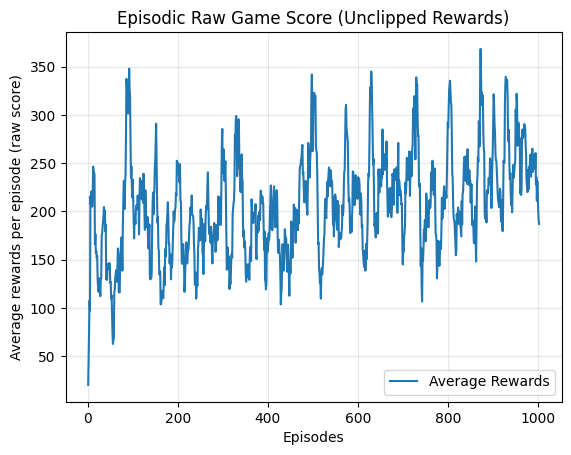

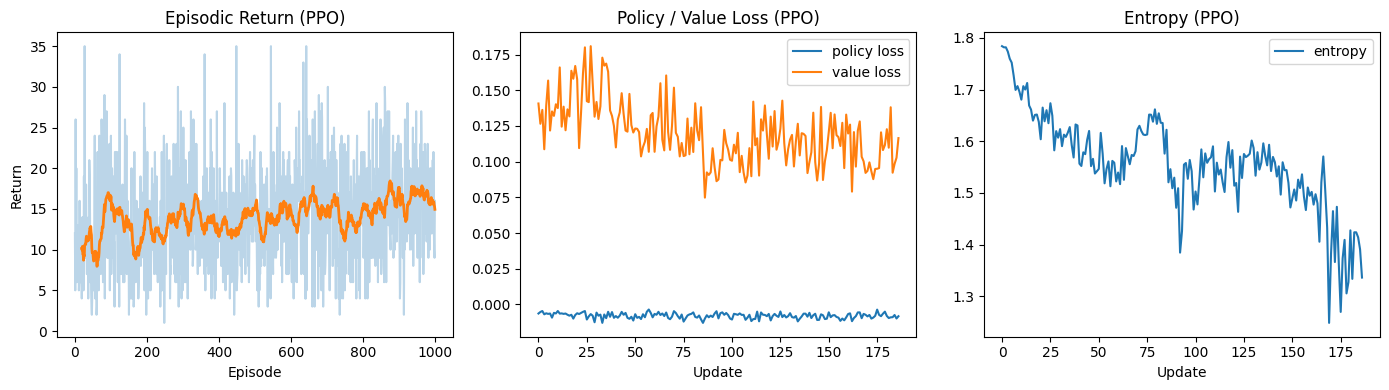


Eval (greedy, RAW score, 10 eps): 264.5 ± 177.7


In [ ]:
# **** PPO agent training with hyperparameters ****
vec_env = make_vec_env(n_envs=6, env_id="ALE/SpaceInvaders-v5", frame_stack=4, obs_type="ram")

#Hyperparamters
agent = AgentPPO(
    env=vec_env,
    gamma=0.99,
    gae_lambda=0.95,    #gae low variance advantage
    hidden_sizes=(512,512),
    learning_rate=4e-4,
    rollout_T=512,       # n step rollout
    entropy_coef=0.015,  # entropy regularisation
    grad_clip=0.5,
    clip_eps=0.2,
    vf_coef=0.75,
    epochs=5,
    minibatch_size=128,
    make_env_fn=lambda: make_single_env("ALE/SpaceInvaders-v5", frame_stack=4, obs_type="ram")()
)

# Stop when last K episodes exceed some threshold
stop_fn = None

agent.train(max_episodes=1000, stop_condition=stop_fn, criterion_episodes=20)
agent.plot_raw_rewards()
agent.plot_like_a2c()

# Evaluation
mean_ret, std_ret = agent.evaluate(n_episodes=10)
# Store the episode metrics
print(f"\nEval (greedy, RAW score, 10 eps): {mean_ret:.1f} ± {std_ret:.1f}")


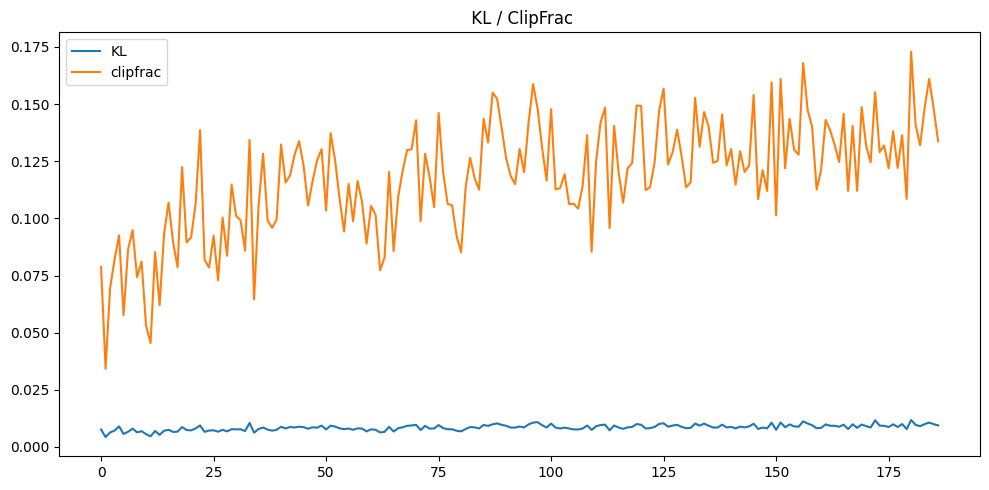


Eval (greedy, RAW score, 10 eps): 201.5 ± 115.9
Video episode reward (raw): 305.0


In [ ]:
agent.plot_convergence()


# **** Build a single eval env ****
def make_eval_env(env_id="ALE/SpaceInvaders-v5", frame_stack=4):
    env = gym.make(env_id, obs_type="ram", render_mode="rgb_array")
    env = RecordEpisodeStatistics(env)   # no deque_size for your version
    env = RamNormalize(env)
    env = RamFrameStack(env, k=frame_stack)
    return env

# Evaluation of N episodes (RAW, no reward clipping in eval loop)
mean_ret, std_ret = agent.evaluate(n_episodes=10)
print(f"\nEval (greedy, RAW score, 10 eps): {mean_ret:.1f} ± {std_ret:.1f}")

# One episode video
eval_env = make_eval_env("ALE/SpaceInvaders-v5", frame_stack=4)
state, _ = eval_env.reset()

terminated = truncated = False
frames, total_reward, steps = [], 0.0, 0
max_steps = 5000  # safety cap for demo videos

while not (terminated or truncated or steps > max_steps):
    # render a frame (HxWxC, uint8)
    frame = eval_env.render()
    # some gym versions might return a list
    if isinstance(frame, list):
        frame = frame[0]
    frames.append(frame)

    # greedy action from your trained policy
    action = agent.policy(state)  # expects stacked/normalized obs
    state, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    steps += 1

print(f"Video episode reward (raw): {total_reward:.1f}")
eval_env.close()

clip = ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))


## 3. Output comparison

In [ ]:
# **** Combined comparison reward plot ****
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def moving_average(x, k=20):
    x = np.asarray(x, dtype=np.float32)
    if x.size == 0: return x
    k = max(1, int(k))
    return np.convolve(x, np.ones(k)/k, mode="valid")

def load_series(csv_path):
    df = pd.read_csv(csv_path)
    # Plot raw_return
    return df["episode"].to_numpy(), df["raw_return"].to_numpy(dtype=np.float32)

def plot_compare_from_csv(csvs_and_labels, ma_window=20, align="none", save_path=None):
    """
    csvs_and_labels: list of (label, path_to_csv)
    align: "none" -> use native lengths,
           "min"  -> trim all to shortest,
           "max"  -> pad with NaNs so shorter lines end naturally
    """
    series = []
    labels = []
    for label, path in csvs_and_labels:
        try:
            ep, raw = load_series(path)
            series.append((ep, raw))
            labels.append(label)
        except Exception as e:
            print(f"[warn] skip {label} ({path}): {e}")

    if not series:
        print("No data found.")
        return

    # align if requested
    if align in ("min", "max"):
        Ls = [len(s[1]) for s in series]
        Lmin, Lmax = min(Ls), max(Ls)
        aligned = []
        for (ep, raw) in series:
            if align == "min":
                aligned.append((ep[:Lmin], raw[:Lmin]))
            else:  # "max"
                pad = Lmax - len(raw)
                if pad > 0:
                    raw = np.pad(raw, (0, pad), constant_values=np.nan)
                    ep  = np.arange(1, len(raw)+1)
                aligned.append((ep, raw))
        series = aligned

    # plot
    plt.figure(figsize=(12,6))
    for (label, (ep, raw)) in zip(labels, series):
        if len(raw) >= ma_window:
            ma = moving_average(raw, ma_window)
            x  = ep[(ma_window-1): (ma_window-1)+len(ma)]
            plt.plot(x, ma, label=label)
        else:
            plt.plot(ep, raw, label=label)

    plt.xlabel("Episodes")
    plt.ylabel("Average rewards per episode (raw score)")
    plt.title("Agent Comparison (Raw Episodic Reward)")
    plt.grid(True, alpha=0.25)
    plt.legend()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


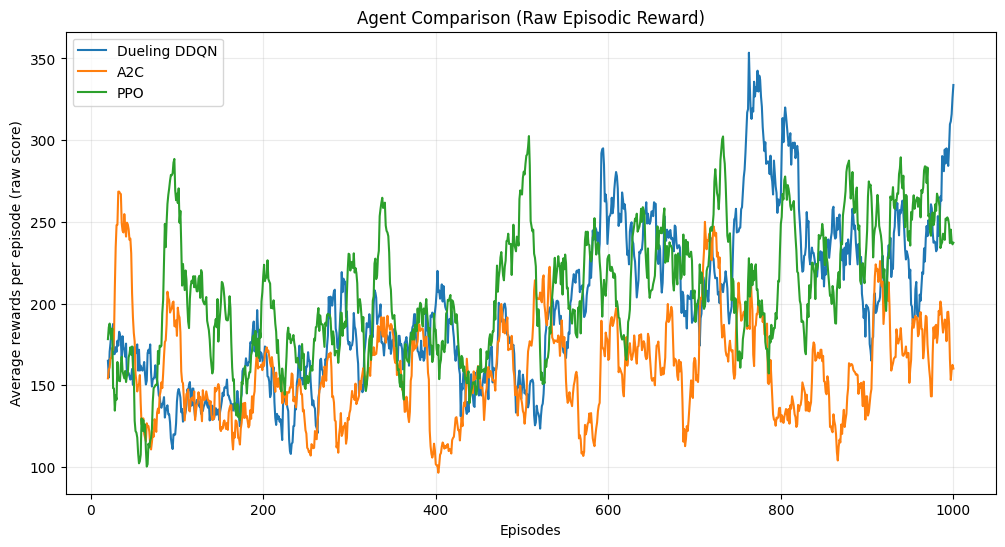

In [ ]:
#Plotting:
plot_compare_from_csv(
    [
        ("Dueling DDQN", f"{base_dir}/DuelingDDQN_raw_rewards.csv"),
        ("A2C",          f"{base_dir}/A2C_raw_rewards.csv"),
        ("PPO",          f"{base_dir}/PPO_raw_rewards.csv"),
    ],
    ma_window=20,
    align="min"
)

Agent Performance Summary

| Agent | Avg. Reward (Training Peak) | Cumulative Reward (Testing) | Observation |
|:------|-----------------------------:|-----------------------------|-------------|
| **Dueling DDQN** | ~280-300 | 260 |Highest reward during training, but lowest at the testing |
| **A2C** | ~150-200 | 285 | Reward fluctuating during training, at the test it shows that agent learned well |
| **PPO** | ~270-290 | 305 |Higher reward during training near DDQN, performed the best at test, which tells us that it generalized well. |

**Observations:**  
- In the reward comparison plot shows that **Dueling DDQN achieved the highest average reward per episode** during the training, but in the testing its performance decreased, indicating overfitting or low generalisation.  
- **PPO**, shows almost equal average reward during the training, and it achieved **highest reward (305)** in the test, showing strong policy stability.  
- **A2C** is the lowest performed agent in the training, looks very slow learning, but in the test it achieved better result than Dueling-DDQN which shows stable training.

**In conclusion**, PPO agent performed higher all the time as I am running so many different times with different parameters comparing with the other 2 agents and achieved highest testing score in the test after training. Dueling DDQN improved significantly after all the improvements, but still showing limited generalisation. A2C agents has the slowest converged during the training and learning slowly.

## 4. Additional -  showing earlier implementation evidence of Agent experiment
#### Note: Those outputs only copied from older versions of codes for showing purpose. So, not able to rerun to get the same result in this notebook.

## 4.1 DDQN agent implementation - earlier result

4.1.1 First we tried DDQN only implementation
*  Training reward: 150-200
*  Test reward result: 120 **bold text**

Observation space: Box(0, 255, (128,), uint8)
Action space: Discrete(6)
Episode 500 done: steps = 275735, rewards = 180.0     

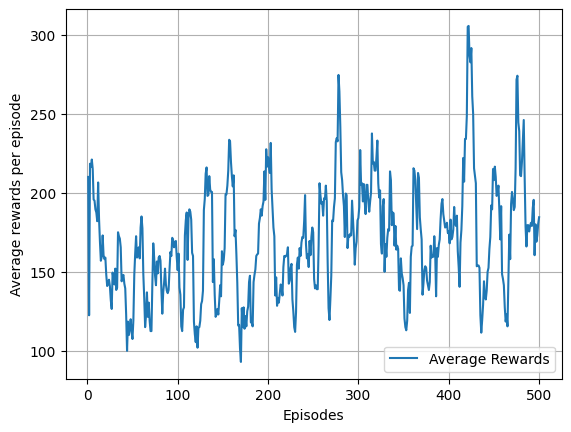

Reward: 120.0


In [ ]:
# Space Invaders (RAM)
ENV_ID = "ALE/SpaceInvaders-v5"
env = gym.make(ENV_ID, obs_type="ram")
eval_env = gym.make(ENV_ID, obs_type="ram", render_mode="rgb_array")

# Header showing
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

gamma = 0.99
hidden_sizes = (256, 256)
learning_rate = 1e-3
epsilon = 1.0
replay_size = 200_000
minibatch_size = 128
target_update = 4000  #Changed
max_episodes = 500
max_steps = 5000
criterion_episodes = 20

agent = AgentDDQN(env,
                  gamma=gamma,
                  hidden_sizes=hidden_sizes,
                  learning_rate=learning_rate,
                  epsilon=epsilon,
                  replay_size=replay_size,
                  minibatch_size=minibatch_size,
                  target_update=target_update)

agent.train(max_episodes, lambda x : min(x) >= 200, criterion_episodes)

# visualise one episode
state, _ = eval_env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
frames = []
while not (terminated or truncated or steps > max_steps):
    frames.append(eval_env.render())

    # take action based on policy
    action = agent.policy(preprocess_obs(state))  #Policy also normalised obs

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    steps += 1

print(f'Reward: {total_reward}')


# close the environment
eval_env.close()

# create and play video clip using the frames and given fps
clip = ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Displaying Double DQN convergence plots...


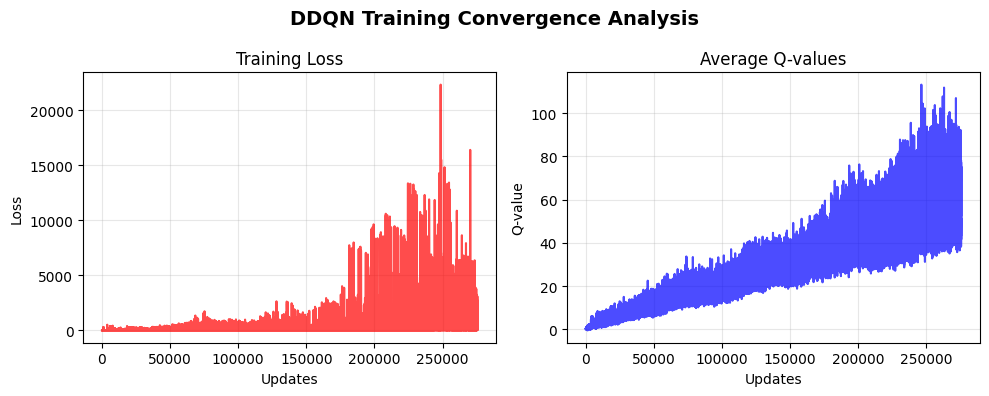

In [ ]:
# Display Double DQN convergence analysis
print("Displaying Double DQN convergence plots...")
agent.plot_convergence()

4.1.2 Second we improved to dueling DDQN implementation
*  Training reward: 200-250
*  Test reward result: 110

Observation space: Box(0, 255, (128,), uint8)
Action space: Discrete(6)
Episode 1000 done: steps = 534170, raw=265.0, clipped=20.0   

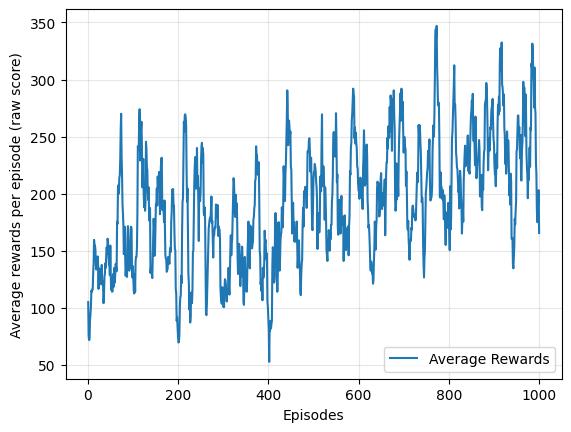

Reward: 110.0

Average evaluation reward over 10 episodes (raw game score): 222.5 ± 134.2


In [ ]:
# Space Invaders (RAM)
ENV_ID = "ALE/SpaceInvaders-v5"
env = gym.make(ENV_ID, obs_type="ram")
eval_env = gym.make(ENV_ID, obs_type="ram", render_mode="rgb_array")

# Header showing
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

gamma = 0.99
hidden_sizes = (256, 256)
learning_rate = 1e-3
epsilon = 1.0
replay_size = 200_000
minibatch_size = 128
target_update = 4000  #Changed
max_episodes = 1000
max_steps = 5000
criterion_episodes = 20

agent = AgentDDQN(env,
                  gamma=gamma,
                  hidden_sizes=hidden_sizes,
                  learning_rate=learning_rate,
                  epsilon=epsilon,
                  replay_size=replay_size,
                  minibatch_size=minibatch_size,
                  target_update=target_update)


agent.train(max_episodes, lambda x : min(x) >= 200, criterion_episodes)

# visualise one episode
state, _ = eval_env.reset()
terminated = False
truncated = False
steps = 0
total_reward = 0
frames = []
while not (terminated or truncated or steps > max_steps):
    frames.append(eval_env.render())

    # take action based on policy
    action = agent.policy(preprocess_obs(state))  #Policy also normalised obs

    # environment receives the action and returns:
    # next observation, reward, terminated, truncated, and additional information (if applicable)
    state, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    steps += 1


print(f'Reward: {total_reward}')

# ---- Evaluate average performance over several runs ----
mean_ret, std_ret = agent.evaluate(n_episodes=10)  # uses the greedy, RAW evaluation method we added
print(f"\nAverage evaluation reward over 10 episodes (raw game score): {mean_ret:.1f} ± {std_ret:.1f}")


# close the environment
eval_env.close()

# create and play video clip using the frames and given fps
clip = ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

Displaying Double DQN convergence plots...


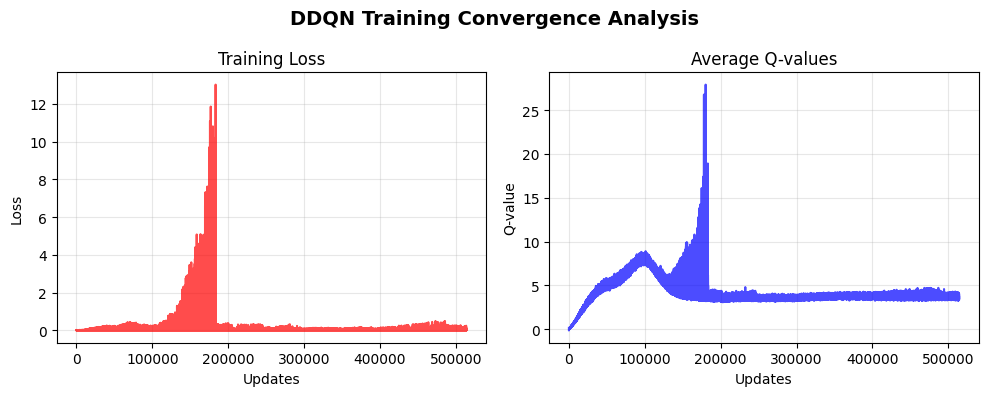

In [ ]:
# Display Double DQN convergence analysis
print("Displaying Double DQN convergence plots...")
agent.plot_convergence()

agent.save('spaceinvaders-ram.DDQN_4.pt')

## 4.2 A2C agent implementation - earlier result

4.2.1 First A2C implementation result
*  Training reward: 150-200
*  Test reward result: 60

Observation space: Box(0, 255, (128,), uint8)
Action space: Discrete(6)
Episode 1000 done: updates=103111, raw=120.0, clipped=8.0   

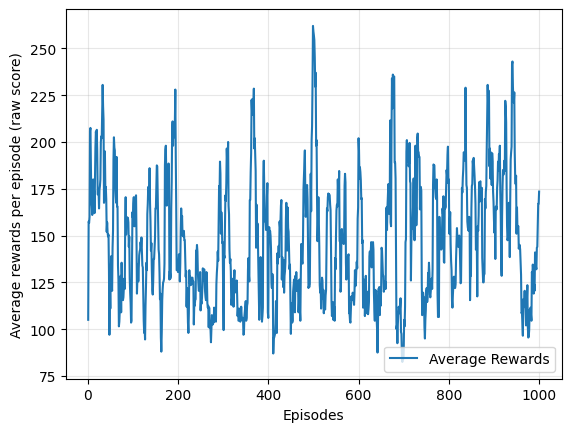

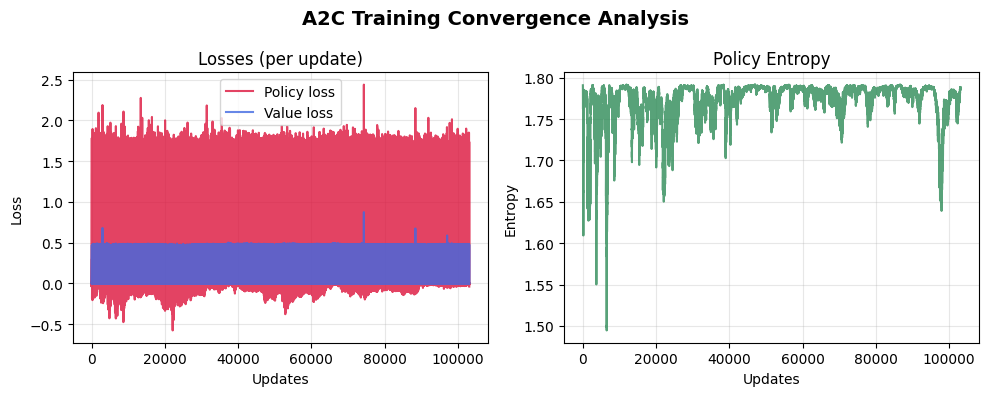


Eval (greedy, RAW score, 10 eps): 60.0 ± 0.0
Video episode reward (raw): 60.0


In [ ]:
# =========================
# Environment (same as DDQN)
# =========================
ENV_ID = "ALE/SpaceInvaders-v5"
env = gym.make(ENV_ID, obs_type="ram")
eval_env = gym.make(ENV_ID, obs_type="ram", render_mode="rgb_array")

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# Common hyperparams (keep similar to DDQN where sensible)
gamma = 0.99
hidden_sizes = (256, 256)
learning_rate = 2.5e-4      # typical A2C lr
max_episodes = 1000          # keep same budget
rollout_T = 5                # T-step on-policy rollout (Practical 9 style)
entropy_coef = 0.01
value_coef = 0.5
grad_clip = 0.5              # actor-critic usually smaller clip than DQN


# =========================
# Train & evaluate (mirrors your DDQN cell)
# =========================
agent = AgentA2C(env,
                 gamma=gamma,
                 hidden_sizes=hidden_sizes,
                 learning_rate=learning_rate,
                 T=rollout_T,
                 entropy_coef=entropy_coef,
                 value_coef=value_coef,
                 grad_clip=grad_clip)

# stop criterion: keep same shape as your DDQN (raw score threshold example)
criterion_episodes = 20
agent.train(max_episodes, lambda lastk: min(lastk) >= 300, criterion_episodes)

# Convergence plots (policy/value loss + entropy)
agent.plot_convergence()

# Greedy evaluation
mean_ret, std_ret = agent.evaluate(n_episodes=10)
print(f"\nEval (greedy, RAW score, 10 eps): {mean_ret:.1f} ± {std_ret:.1f}")

# One-episode video (same as your DDQN visualisation)
state, _ = eval_env.reset()
terminated = truncated = False
steps, total_reward = 0, 0.0
max_steps = 5000
frames = []
while not (terminated or truncated or steps > max_steps):
    frames.append(eval_env.render())
    action = agent.policy(preprocess_obs(state))   # greedy action for visual
    state, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    steps += 1

print(f"Video episode reward (raw): {total_reward:.1f}")
eval_env.close()

clip = ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))


## 4.2 PPO agent implementation - earlier result

4.3.1 First PPO implementation result
*  Training reward: 200-250
*  Test reward result: 210

Vector envs: 6 | obs: Box(0.0, 1.0, (512,), float32) | act: Discrete(6)
[PPO] n_envs=6 | rollout_T=512 | obs_dim=512 | actions=6
Ep    4/1000 | pi_loss=-0.008 | v_loss=0.2 | H=1.776 | KL=0.0157 | clipfrac=0.095 | recent_avg_ret=7.50
Ep   10/1000 | pi_loss=-0.006 | v_loss=0.1 | H=1.758 | KL=0.0076 | clipfrac=0.035 | recent_avg_ret=8.50
Ep   16/1000 | pi_loss=-0.009 | v_loss=0.1 | H=1.754 | KL=0.0119 | clipfrac=0.102 | recent_avg_ret=9.31
Ep   22/1000 | pi_loss=-0.009 | v_loss=0.1 | H=1.746 | KL=0.0120 | clipfrac=0.093 | recent_avg_ret=9.35
Ep   28/1000 | pi_loss=-0.009 | v_loss=0.1 | H=1.719 | KL=0.0115 | clipfrac=0.088 | recent_avg_ret=9.35
Ep   35/1000 | pi_loss=-0.011 | v_loss=0.1 | H=1.709 | KL=0.0134 | clipfrac=0.124 | recent_avg_ret=8.60
Ep   40/1000 | pi_loss=-0.010 | v_loss=0.1 | H=1.722 | KL=0.0106 | clipfrac=0.084 | recent_avg_ret=8.40
Ep   48/1000 | pi_loss=-0.014 | v_loss=0.1 | H=1.720 | KL=0.0123 | clipfrac=0.102 | recent_avg_ret=8.50
Ep   55/1000 | pi_loss=-0.011 | v_loss=

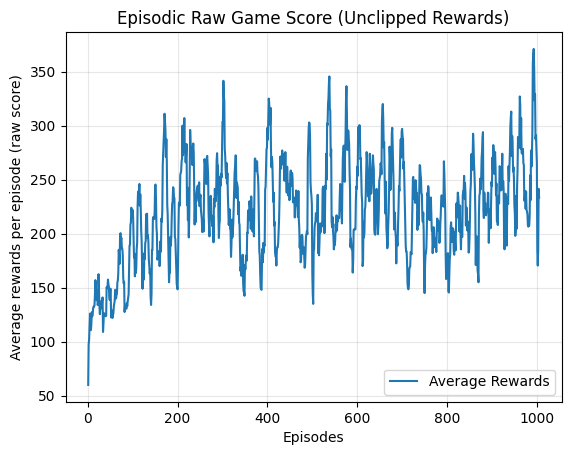

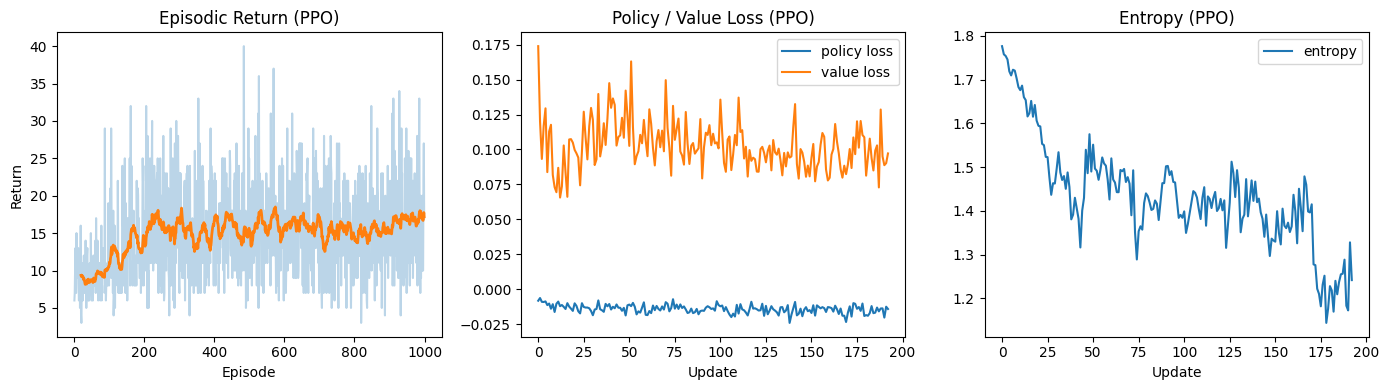


Eval (greedy, RAW score, 10 eps): 158.5 ± 51.3


In [ ]:
# =========================
# Build env, train, plot
# =========================
vec_env = make_vec_env(n_envs=6, env_id="ALE/SpaceInvaders-v5", frame_stack=4, obs_type="ram")

agent = AgentPPO(
    env=vec_env,
    gamma=0.99,
    gae_lambda=0.95,
    hidden_sizes=(512,512),
    learning_rate=5e-4,
    rollout_T=512,
    entropy_coef=0.015,
    grad_clip=0.5,
    clip_eps=0.25,
    vf_coef=0.60,
    epochs=6,
    minibatch_size=128,
    make_env_fn=lambda: make_single_env("ALE/SpaceInvaders-v5", frame_stack=4, obs_type="ram")()
)

# stop when last K episodes exceed some threshold
stop_fn = None

agent.train(max_episodes=1000, stop_condition=stop_fn, criterion_episodes=20)
agent.plot_raw_rewards()
agent.plot_like_a2c()

mean_ret, std_ret = agent.evaluate(n_episodes=10)
print(f"\nEval (greedy, RAW score, 10 eps): {mean_ret:.1f} ± {std_ret:.1f}")


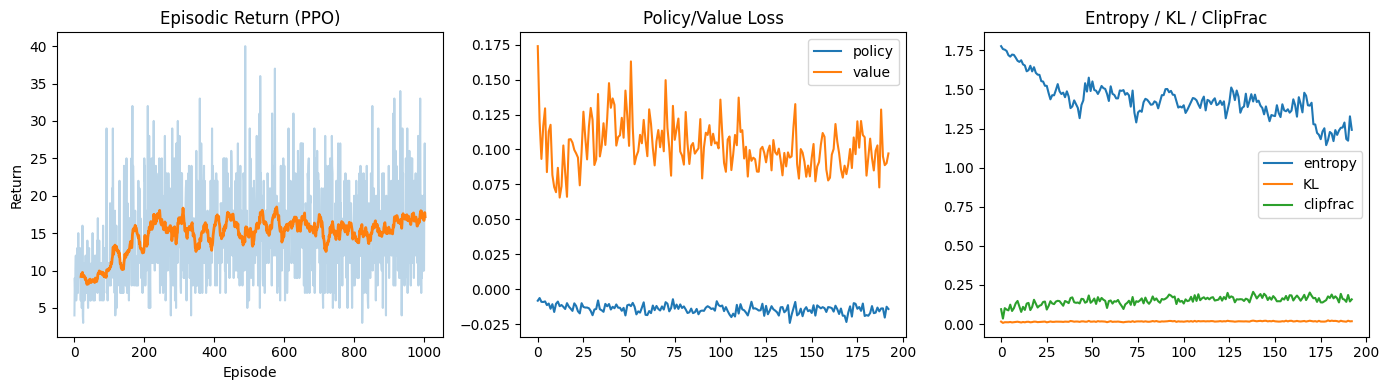


Eval (greedy, RAW score, 10 eps): 157.0 ± 101.9
Video episode reward (raw): 210.0


In [ ]:
agent.plot_convergence()


# --- Build a single eval env with rendering ---
def make_eval_env(env_id="ALE/SpaceInvaders-v5", frame_stack=4):
    env = gym.make(env_id, obs_type="ram", render_mode="rgb_array")
    env = RecordEpisodeStatistics(env)   # no deque_size for your version
    env = RamNormalize(env)
    env = RamFrameStack(env, k=frame_stack)
    return env

# use evaluation of N episodes (RAW, no reward clipping in eval loop)
mean_ret, std_ret = agent.evaluate(n_episodes=10)
print(f"\nEval (greedy, RAW score, 10 eps): {mean_ret:.1f} ± {std_ret:.1f}")

# Video
eval_env = make_eval_env("ALE/SpaceInvaders-v5", frame_stack=4)
state, _ = eval_env.reset()

terminated = truncated = False
frames, total_reward, steps = [], 0.0, 0
max_steps = 5000  # safety cap for demo videos

while not (terminated or truncated or steps > max_steps):
    # render a frame (HxWxC, uint8)
    frame = eval_env.render()
    # some gym versions might return a list; handle both
    if isinstance(frame, list):
        frame = frame[0]
    frames.append(frame)

    # greedy action from your trained policy
    action = agent.policy(state)  # expects stacked/normalized obs (OK with this env)
    state, reward, terminated, truncated, info = eval_env.step(action)
    total_reward += reward
    steps += 1

print(f"Video episode reward (raw): {total_reward:.1f}")
eval_env.close()

clip = ImageSequenceClip(frames, fps=50)
clip.ipython_display(rd_kwargs=dict(logger=None))

